PCA!

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# CPU PCA
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

# GPU PCA
import cudf
from cuml import PCA as cuPCA
from cuml import Ridge as cumlRidge

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(25, 12.5)})

We are going to work with the [fashion mnist](https://github.com/zalandoresearch/fashion-mnist) data set.  This is a dataset consisting of 70,000 28x28 grayscale images of clothing.

In [3]:
if not os.path.exists('fashion_mnist'):
    !git clone https://github.com/zalandoresearch/fashion-mnist.git fashion_mnist

In [4]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [5]:
train, train_labels = load_mnist('fashion_mnist/data/fashion', kind='train')
test, test_labels = load_mnist('fashion_mnist/data/fashion', kind='t10k')
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.array(np.hstack([train_labels, test_labels]))

There are 60000 training images and 10000 test images

In [6]:
f"Train shape: {train.shape} and Test Shape: {test.shape}"

'Train shape: (60000, 784) and Test Shape: (10000, 784)'

In [7]:
train[0].shape

(784,)

As mentioned previously, each row in the train matrix is an image

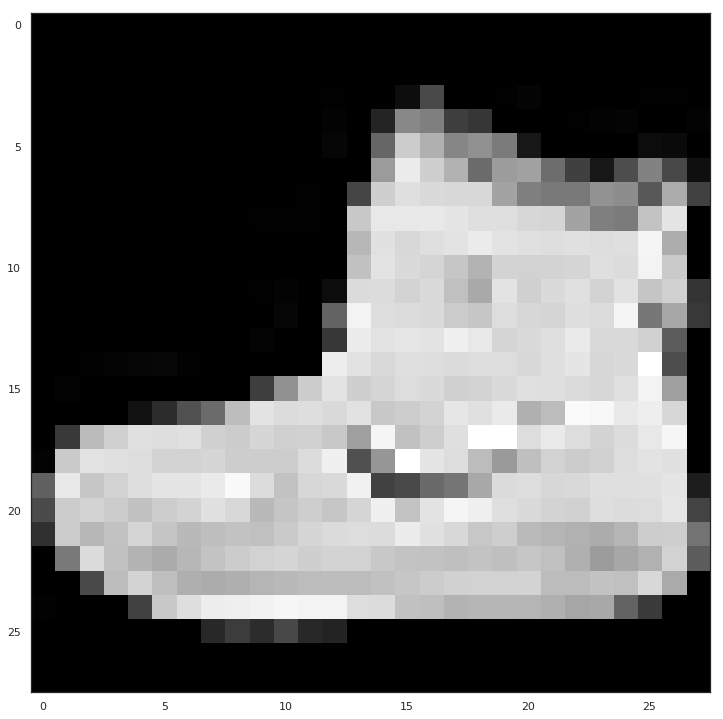

In [8]:
# display a Nike? sneaker
pixels = train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')

There is cost with moving data between host memory and device memory (GPU memory) and we will include that core when comparing speeds

In [9]:
f'Data in memory: {data.nbytes / 1e6} MB'

'Data in memory: 439.04 MB'

In [10]:
%%time
record_data = (('fea%d'%i, data[:,i]) for i in range(data.shape[1]))
gdf = cudf.DataFrame(record_data)

CPU times: user 5.06 s, sys: 4.62 s, total: 9.68 s
Wall time: 9.95 s


In [11]:
%%time
cupca = cuPCA(n_components=2).fit(gdf)
print(cupca.explained_variance_.to_array())

[19.80952039 12.09336552]
CPU times: user 3.12 s, sys: 280 ms, total: 3.4 s
Wall time: 3.39 s


In [12]:
%%time
pca = PCA(n_components=2).fit(data)
print(pca.explained_variance_)

[19.80952039 12.09336552]
CPU times: user 28.5 s, sys: 1.33 s, total: 29.8 s
Wall time: 981 ms


The above timing measurements shows that GPU PCA is not as performant as the refernce/CPU PCA from sklearn when dealing with smallish data ~440MB. When the data grows in size, however, we'll see that the cuml implementation signficantly out performs the sklearn implementation

In [13]:
dup_data = np.array(np.vstack([data]*10))
dup_target = np.array(np.hstack([target]*10))
# print(dup_data.nbytes / 1e6, data.nbytes / 1e6)
# print(dup_data.shape, data.shape)
print(f'Duplicated data in memory: {dup_data.nbytes / 1e6} MB')

Duplicated data in memory: 4390.4 MB


In [14]:
%%time
record_data = (('fea%d'%i, dup_data[:,i]) for i in range(dup_data.shape[1]))
gdf = cudf.DataFrame(record_data)

CPU times: user 38.7 s, sys: 9.57 s, total: 48.2 s
Wall time: 48 s


In [15]:
cu_ride = cumlRidge()
cu_pca = cuPCA()
pca = PCA()
ridge = Ridge()
cu_pipe = Pipeline(steps=[('pca', cu_pca), ('ridge', cu_ride)])
pipe = Pipeline(steps=[('pca', pca), ('ridge', ridge)])

In [16]:
%%time
params = {'pca__n_components': [2, 10, 20],
          'ridge__alpha': np.array([0.1]) #np.logspace(-3, -1, 30)
         }

estimator = GridSearchCV(pipe,params, scoring='r2', cv=5)
estimator.fit(data, target)

CPU times: user 12min 46s, sys: 38.5 s, total: 13min 24s
Wall time: 24.7 s


In [17]:
estimator.best_params_

{'pca__n_components': 20, 'ridge__alpha': 0.1}

In [18]:
%%time
cu_ride = cumlRidge()
cu_pca = cuPCA()
cu_pipe = Pipeline(steps=[('pca', cu_pca), ('ridge', cu_ride)])
pipe = Pipeline(steps=[('pca', pca), ('ridge', ridge)])
params = {'pca__n_components': [2, 10, 20],
          'ridge__alpha': np.array([0.1])
         }

estimator = GridSearchCV(cu_pipe, params, scoring='r2', cv=5)
estimator.fit(data, target)

CPU times: user 6min 9s, sys: 15.1 s, total: 6min 24s
Wall time: 6min 24s


In [19]:
estimator.best_params_

{'pca__n_components': 2, 'ridge__alpha': 0.1}

In [ ]:
import dask_ml.model_selection as dcv
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

# Start one worker per GPU on the local system
cluster = LocalCUDACluster()
client = Client(cluster)
client